In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Input
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#!/bin/bash
!curl -L -o '/content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/chess.zip' https://www.kaggle.com/api/v1/datasets/download/anshulmehtakaggl/chess-pieces-detection-images-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 3555k  100 3555k    0     0  4934k      0 --:--:-- --:--:-- --:--:-- 4934k


In [4]:
!unzip '/content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/chess.zip' -d '/content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN'

Archive:  /content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/chess.zip
  inflating: /content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/Queen-Resized/00000000_resized.jpg  
  inflating: /content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/Queen-Resized/00000001_resized.jpg  
  inflating: /content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/Queen-Resized/00000003_resized.jpg  
  inflating: /content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/Queen-Resized/00000004_resized.jpg  
  inflating: /content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/Queen-Resized/00000005_resized.jpg  
  inflating: /content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/Queen-Resized/00000007_resized.jpg  
  inflating: /content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/Queen-Resized/00000008_resized.jpg  
  inflating: /content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN/Queen-Resized/00000010_

In [6]:
# Path to chess piece images
dataset_path = '/content/drive/MyDrive/CSE 432 ML/ Image Classification using CNN'
img_size = (224, 224)
batch_size = 32
seed = 42

In [7]:
# Load full dataset
full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True  # Shuffle before splitting
)

Found 651 files belonging to 5 classes.


In [8]:
# Split manually: 80% train, 20% test
dataset_size = len(full_ds)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size

train_ds = full_ds.take(train_size)
test_ds = full_ds.skip(train_size)

In [9]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomContrast

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomContrast(0.2),
])

In [10]:
# Apply augmentation
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

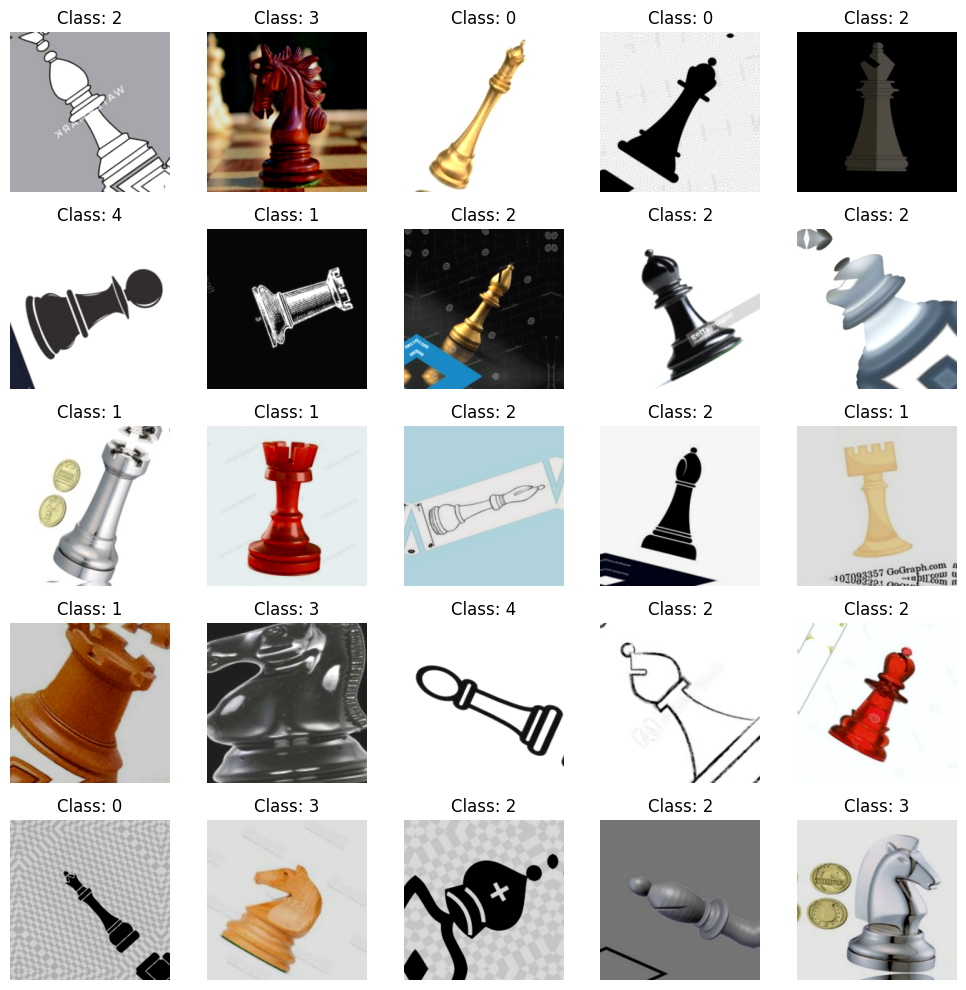

In [11]:
# Show Images

import matplotlib.pyplot as plt

# Take a single batch of images from the augmented training dataset
image_batch, label_batch = next(iter(augmented_train_ds))

# Number of images to display (25 in a 5x5 grid)
num_images_to_display = 25

# Create a 5x5 grid for the images
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

# Iterate over the images in the batch
for i in range(num_images_to_display):
  ax = axes[i // 5, i % 5]  # Get the current subplot
  ax.imshow(image_batch[i].numpy().astype("uint8"))  # Display the image
  ax.set_title(f"Class: {label_batch[i].numpy()}")  # Set the class label as the title
  ax.axis("off")  # Turn off axes

plt.tight_layout()
plt.show()


In [12]:
# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [14]:
# Build Custom CNN model
model = Sequential([
    Input(shape=(img_size[0], img_size[1], 3), name='input_layer'),
    Rescaling(1./255),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(full_ds.class_names), activation='softmax')
])

# Compile
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,524,805 (24.89 MB)

 Trainable params: 6,524,805 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train
history = model.fit(augmented_train_ds, epochs=10)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 90s 5s/step - accuracy: 0.2315 - loss: 2.9999
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.2544 - loss: 1.5968
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 5s/step - accuracy: 0.2754 - loss: 1.5904
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.2686 - loss: 1.5975
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - accuracy: 0.2337 - loss: 1.5946
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 5s/step - accuracy: 0.2609 - loss: 1.5886
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.2297 - loss: 1.5858
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.2374 - loss: 1.6009
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 88s 6s/step - accuracy: 0.2467 - loss: 1.5955
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.2499 - loss: 1.5896


In [ ]:
# Test
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - accuracy: 0.4373 - loss: 1.5698
Test Accuracy: 0.44


In [ ]:
# Transfer Learning

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load pre-trained VGG16 model (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(len(full_ds.class_names), activation='softmax')
])


# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(augmented_train_ds, epochs=10)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,139,014 (80.64 MB)

 Trainable params: 6,424,326 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
 5/14 ━━━━━━━━━━━━━━━━━━━━ 3:01 20s/step - accuracy: 0.2470 - loss: 54.1175

KeyboardInterrupt: 